# Training a CNN-LSTM Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import os
from typing import Callable

import numpy as np
import pandas as pd
import tensorflow as tf
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation, layers, losses

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
logger = log.DummyLogger(verbose=False)

INFO: Printing to Stdout


## Configuration

In [4]:
%pwd

'/tf/workspace/notebooks'

In [5]:
PROJECT = "PXD010000"
DUMP_PATH = os.path.join("..", "dumps", PROJECT)
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "*_mzmlid.parquet")
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

In [6]:
SEQ = 'peptide_sequence'

In [7]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 2354,
  'intensity_array': 2354,
  'peptide_sequence': 50},
 'idx_to_char': {'0': 'A',
  '1': 'C',
  '2': 'D',
  '3': 'E',
  '4': 'F',
  '5': 'G',
  '6': 'H',
  '7': 'I',
  '8': 'K',
  '9': 'L',
  '10': 'M',
  '11': 'M(Oxidation)',
  '12': 'N',
  '13': 'P',
  '14': 'Q',
  '15': 'R',
  '16': 'S',
  '17': 'T',
  '18': 'V',
  '19': 'W',
  '20': 'Y',
  '21': '_'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7fa6046d5158>'},
 'split_value_columns': ['species', 'istrain'],
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence']}

In [8]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [9]:
KEEP_CACHE = True

In [10]:
TRAINING_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [11]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*',  # filename
        '*',  # species
        '*'   # istrain
    ),
    path_position = -2,
    splits = {
            TRAINING_TYPE: 0.4,
            TEST_TYPE: 0.5,
            EVAL_TYPE: 0.6
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)

INFO: found file paths dump '../dumps/PXD010000/training_columns/tf_datasets/dataset_file_paths.json'

assigned dataset files:
#Train = 89
e.g.: ../dumps/PXD010000/training_columns/tf_datasets/Biodiversity_C_indologenes_LIB_aerobic_02_03May16_Samwise_16-03-32_mzmlid.parquet/Chryseobacterium_indologenes/Train
#Test = 17
e.g.: ../dumps/PXD010000/training_columns/tf_datasets/Biodiversity_A_cryptum_FeTSB_anaerobic_1_01Jun16_Pippin_16-03-39_mzmlid.parquet/Acidiphilium_cryptum_JF-5/Train
#Eval = 29
e.g.: ../dumps/PXD010000/training_columns/tf_datasets/Biodiversity_B_fragilis_CMcarb_anaerobic_01_01Feb16_Arwen_15-07-13_mzmlid.parquet/Bacteroides_fragilis_638R/Train


### Loading corresponding TF datasets

In [12]:
element_spec = (
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col], ), dtype=tf.float32)
     for col in PROCESSING_INFO['training_data_columns']),
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col], ), dtype=tf.int8)
     for col in PROCESSING_INFO['target_data_columns'])
)
element_spec

((TensorSpec(shape=(2354,), dtype=tf.float32, name=None),
  TensorSpec(shape=(2354,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(50,), dtype=tf.int8, name=None),))

In [13]:
BATCH_SIZE=32

In [14]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    keep_cache=KEEP_CACHE,
    logger=logger
).load_datasets_by_type(dataset_file_paths)
datasets

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:1640: UserWarning: The `deterministic` argument has no effect unless the `num_parallel_calls` argument is specified.
  warnings.warn("The `deterministic` argument has no effect unless the "


{'Train': <BatchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Test': <BatchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Eval': <BatchDataset shapes: (((32, 2354), (32, 2354)), ((32, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>}

## Building the Tensorflow Model

In [15]:
input_layers_list, masked_input_layers_list = layers.create_masked_input_layers(
    [
        layers.InputLayerConfiguration(
            name=col,
            shape=PROCESSING_INFO['padding_lengths'][col],
            mask_value=PROCESSING_INFO['padding_characters'][col]
        )
        for col in PROCESSING_INFO['training_data_columns']
    ]
)
print(input_layers_list)
print(masked_input_layers_list)

[<KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'mz_array')>, <KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'intensity_array')>]
[<KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'masked_mz_array')>, <KerasTensor: shape=(None, 2354) dtype=float32 (created by layer 'masked_intensity_array')>]


In [16]:
masked_loss = losses.MaskedLoss(
    loss_function=tf.keras.losses.sparse_categorical_crossentropy,
    masking_value=tf.constant(
        value=char_to_idx[PROCESSING_INFO['padding_characters'][SEQ]],
        dtype=tf.int8
    )
)

In [17]:
def add_conv_layers_until_size_is_small(previous_layer):
    pool_size=2

    x = previous_layer
    
    while x.shape[1] >= (pool_size + 1)*PROCESSING_INFO['padding_lengths'][SEQ]:
        x = tf.keras.layers.Conv1D(
            filters=22,
            kernel_size=42,
            activation='relu',
        )(x)
        print(x)
        x = tf.keras.layers.MaxPool1D(
            pool_size=2,
            padding='same',
        )(x)
        print(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        print(x)
    
    return x

def build_model_with_stacked_convolutions(
    model_name: str = "mmproteo_lstm_with_pooling"
) -> tf.keras.Model:
    x = tf.stack(
        values=masked_input_layers_list, 
        axis=-1,
    )
    y = tf.keras.layers.Conv1D(
        filters=42,
        kernel_size=100,
        padding='same',
        activation='relu',
    )(x)
    x = tf.concat(
        values=[x, y],
        axis=-1
    )
    x = tf.keras.layers.Bidirectional(
        layer=tf.keras.layers.LSTM(
            units=256,
            return_sequences=True,
        )
    )(x)
    x = add_conv_layers_until_size_is_small(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        units=PROCESSING_INFO['padding_lengths'][SEQ]*len(idx_to_char),
        activation=None,
    )(x)
    x = tf.reshape(x,(-1, PROCESSING_INFO['padding_lengths'][SEQ], len(idx_to_char)))

    x = tf.keras.activations.softmax(x)

    model = tf.keras.Model(
        inputs=input_layers_list, 
        outputs=x, 
        name=f"{model_name}_{utils.get_current_time_str()}")
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#masked_loss,
                  metrics=[
                      tf.keras.metrics.SparseCategoricalAccuracy(),
                      tf.keras.metrics.SparseCategoricalCrossentropy()
                  ]
                 )
    return model

In [18]:
def build_lstm_with_pooling_model(
    model_name: str = "mmproteo_lstm_with_pooling"
) -> tf.keras.Model:
    x = tf.stack(
        values=masked_input_layers_list, 
        axis=-1,
    )
    
    dense_y = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(
            units=16,
            activation='relu',
            name='y_time_distributed_dense',
        )
    )(x)
    cnn_1_y = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=1,
        activation='relu',
        name="y_conv_1_16",
    )(x)
    cnn_10_y = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=10,
        activation='relu',
        padding='same',
        name="y_conv_10_16",
    )(x)
    cnn_100_y = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=100,
        activation='relu',
        padding='same',
        name="y_conv_100_16",
    )(x)
    
    x = tf.concat(
        values=[dense_y, cnn_1_y, cnn_10_y, cnn_100_y],
        axis=-1
    )
    
    y = x
    for i in range(3):
        y = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(
                units=64,
                activation='relu',
                name=f'pre_lstm_time_distributed_dense_{i}',
            )
        )(y)
    
    x = tf.concat(
        values=[x, y],
        axis=-1,
    )
    
    x = tf.keras.layers.Bidirectional(
        layer=tf.keras.layers.LSTM(
            units=128,
            return_sequences=True,
            name='lstm'
        )
    )(x)
    
    x = tf.keras.layers.GlobalMaxPooling1D(
        name='global_max_pooling_over_time',
    )(x)
    
    for i in range(3):
        x = tf.keras.layers.Dense(
            units=2**(8+i),
            activation='relu',
            name=f"upscaling_dense_{i}",
        )(x)
    
    x = tf.keras.layers.Dense(
        units=PROCESSING_INFO['padding_lengths'][SEQ]*len(idx_to_char),
        activation=None,
        name="final_dense",
    )(x)
    
    x = tf.reshape(x,(-1, PROCESSING_INFO['padding_lengths'][SEQ], len(idx_to_char)))
    
    x = tf.keras.activations.softmax(x)
    
    model = tf.keras.Model(
        inputs=input_layers_list, 
        outputs=x, 
        name=f"{model_name}_{utils.get_current_time_str()}")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),#masked_loss,
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(),
            tf.keras.metrics.SparseCategoricalCrossentropy()
        ]
    )
    
    return model

In [19]:
model = build_lstm_with_pooling_model()

In [20]:
MODEL_PATH = os.path.join(DUMP_PATH, "models", model.name)
MODEL_PATH

'../dumps/PXD010000/models/mmproteo_lstm_with_pooling_20210628-105901'

In [21]:
utils.ensure_dir_exists(MODEL_PATH)

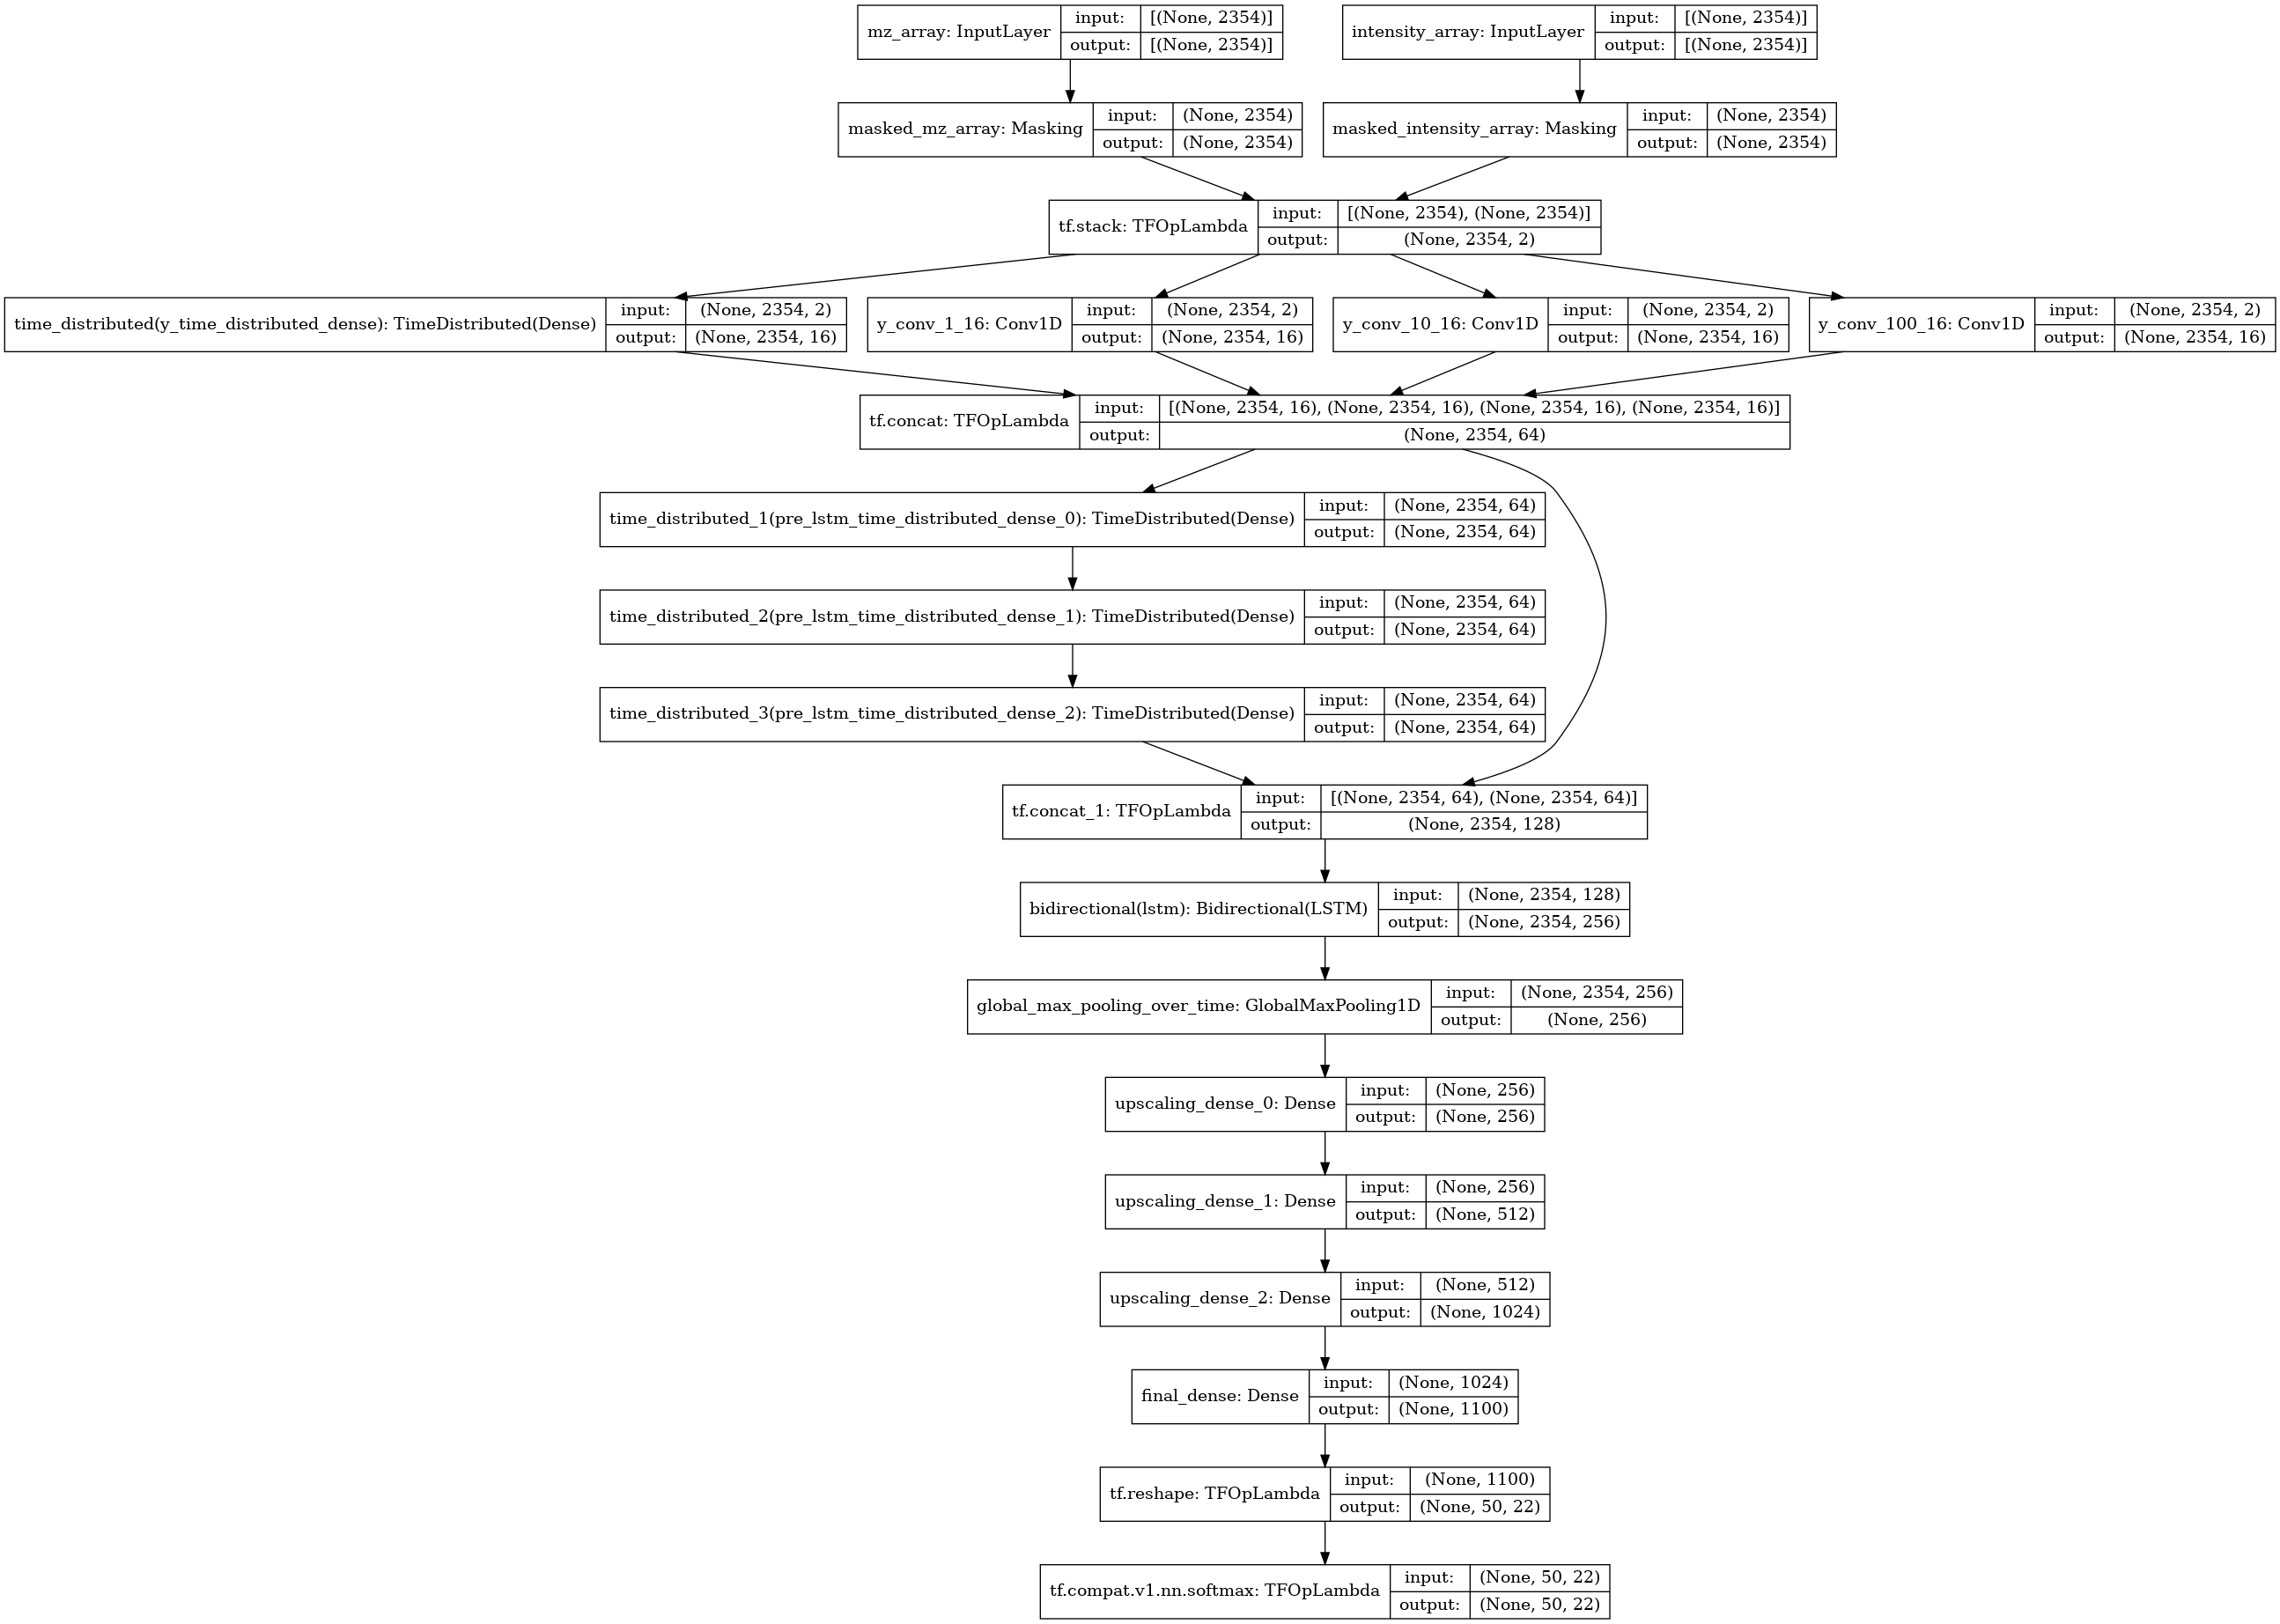

In [22]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True
)

In [23]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")
    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_lstm_with_pooling_20210628-105901"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mz_array (InputLayer)           [(None, 2354)]       0                                            
__________________________________________________________________________________________________
intensity_array (InputLayer)    [(None, 2354)]       0                                            
__________________________________________________________________________________________________
masked_mz_array (Masking)       (None, 2354)         0           mz_array[0][0]                   
__________________________________________________________________________________________________
masked_intensity_array (Masking (None, 2354)         0           intensity_array[0][0]            
_________________________________________________________

In [24]:
with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
    file.write(model.to_json())

In [25]:
with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
    file.write(model.to_yaml())

In [26]:
assert False

AssertionError: 

## Training the Tensorflow Model

In [29]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [30]:
TENSORBOARD_LOG_DIR = os.path.join(MODEL_PATH, "tensorboard")
os.path.realpath(TENSORBOARD_LOG_DIR)

'/tf/workspace/dumps/PXD010000/models/mmproteo_lstm_with_pooling_20210628-105901/tensorboard'

In [31]:
%tensorboard --logdir $TENSORBOARD_LOG_DIR --bind_all

In [33]:
model.fit(x=datasets[TRAINING_TYPE].repeat(),
          validation_data=datasets[TEST_TYPE].repeat(), 
          validation_steps=500,
          epochs=1,
          steps_per_epoch=1_000,
          callbacks=callbacks.create_callbacks(
              tensorboard=True,
              progressbar=False,
              reduce_lr=True,
              early_stopping=True,
              checkpoints=True,
              csv=True,
              base_path=MODEL_PATH,
          )
         )

1000/1000 [==============================] - 197s 196ms/step - loss: 1.0360 - sparse_categorical_accuracy: 0.7011 - sparse_categorical_crossentropy: 1.0360 - val_loss: 0.9417 - val_sparse_categorical_accuracy: 0.7291 - val_sparse_categorical_crossentropy: 0.9417


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_20210628-105901/checkpoints/assets


INFO:tensorflow:Assets written to: ../dumps/PXD010000/models/mmproteo_lstm_with_pooling_20210628-105901/checkpoints/assets


## Evaluating the Tensorflow Model

In [34]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

In [35]:
evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [36]:
evaluator.evaluate_model(model)

1250/1250 [==============================] - 81s 63ms/step - loss: 0.9365 - sparse_categorical_accuracy: 0.7272 - sparse_categorical_crossentropy: 0.9365


[0.9365091919898987, 0.727183997631073, 0.9365102648735046]

In [37]:
eval_df, (x_eval, y_eval, y_pred) = evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

,predicted,true
0,A L A A A A A A A K _ _ _ _ _ _ _,Q I V A N A G K E G A V V V Q K
1,L L A A A A A R _ _ _ _,V D A Y E E N D M L K
2,A L A A A A A A K _ _ _ _ _ _ _ _ _,S D A L F A L K G E N P E E E A R
3,L L A A A A R _ _ _ _ _ _ _ _,S D E E I A N L A A T D P K
4,L L A A A A A A _ _ _ _ _ _ _,Q I Y D Q I E M G K V E G R
5,A L A A A A A A A _ _,N L A T N H M V Q K
6,A L A A A A A A A _,L A L E E F G S K
7,A L A A A G A A A A A A A _ _ _ _ _ _,R A G A E N K P A E L N D Y A V V K
8,A L A A A A A A A A A _ _ _ _ _ _ _ _,E L V E S P D D A N K S Y N E F K K
9,A L A A A A A A _ _ _ _ _,M L Q S A L Q T A T T R


In [38]:
eval_df.predicted.map(print)
None

A L A A A A A A A K _ _ _ _ _ _ _
L L A A A A A R _ _ _ _
A L A A A A A A K _ _ _ _ _ _ _ _ _
L L A A A A R _ _ _ _ _ _ _ _
L L A A A A A A _ _ _ _ _ _ _
A L A A A A A A A _ _
A L A A A A A A A _
A L A A A G A A A A A A A _ _ _ _ _ _
A L A A A A A A A A A _ _ _ _ _ _ _ _
A L A A A A A A _ _ _ _ _
A L V A A G A A A A A A A
A L A A A A A A A A _ _ _ _ _
A L A A A A A A A _ _ _ _ _ _ _ _ _
A L A A A A A A A A _ _ _
A L V A A G A A A A G V A A L A _ _ _ _ _ _
A I V E A G A A A A G V
L L A A A A A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
A L A A A A A A _ _ _ _ _ _ _ _ _ _
L L A A A A A R _ _ _ _ _ _ _ _
A L A A A G A A A A A A A _ _ _ _ _ _ _


broken loss function?

In [39]:
np.argmax(y_pred[0], axis=1)

array([ 0,  9,  0,  0,  0,  0,  0,  0,  0,  8, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21])

In [40]:
model.predict(datasets[EVAL_TYPE].take(1)).shape

(32, 50, 22)

In [41]:
y_pred.shape

(20, 50, 22)

In [42]:
y_pred

array([[[1.12952985e-01, 2.08425103e-03, 4.64767478e-02, ...,
         7.77593208e-03, 3.21857743e-02, 6.38653137e-06],
        [9.53594968e-02, 3.00728902e-03, 3.71715166e-02, ...,
         5.93554275e-03, 2.84306556e-02, 1.02404611e-05],
        [1.14230700e-01, 8.25294852e-03, 7.84488022e-02, ...,
         5.76385390e-03, 3.08289714e-02, 1.20051827e-05],
        ...,
        [2.82876249e-06, 3.17423292e-06, 3.62222659e-06, ...,
         3.44911859e-06, 3.67138568e-06, 9.99891996e-01],
        [5.30798707e-06, 9.19299146e-06, 4.35348284e-06, ...,
         2.16968124e-06, 2.82018527e-06, 9.99892712e-01],
        [1.64177345e-06, 2.91232709e-06, 3.78252821e-06, ...,
         3.19737569e-06, 4.50130619e-06, 9.99896049e-01]],

       [[1.13479942e-01, 1.73101644e-03, 4.57352810e-02, ...,
         9.81095899e-03, 3.26166563e-02, 1.11444042e-05],
        [1.11542515e-01, 2.59083975e-03, 3.21021862e-02, ...,
         5.06836968e-03, 2.22272407e-02, 1.47605042e-05],
        [1.18558586e-01, 